In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#dataset 120 extraction
import zipfile
import os

#Abnormal
ZIP_PATH_ABNORMAL_120 = "/content/gdrive/MyDrive/120-20231125T140612Z-001.zip"
IMAGE_FOLDER_ABNORMAL_120 = "/content/gdrive/MyDrive/GasHisDB/120"

if not os.path.exists(IMAGE_FOLDER_ABNORMAL_120):
    os.makedirs(IMAGE_FOLDER_ABNORMAL_120)

with zipfile.ZipFile(ZIP_PATH_ABNORMAL_120, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        print(f"Extracting: {file_info.filename}")
        zip_ref.extract(file_info, path=IMAGE_FOLDER_ABNORMAL_120)

In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Path to the folder containing the data
data_folder = '/content/gdrive/MyDrive/GasHisDB/120/120/Abnormal'

# List all files in the folder
file_list = os.listdir(data_folder)

# Splitting the data into train and test sets
train_files, test_files = train_test_split(file_list, test_size=0.3, shuffle=True, random_state=42)

# Create folders for train and test sets if they don't exist
train_folder = '/content/gdrive/MyDrive/GasHisDB/120_dataset/Train/Abnormal'
test_folder = '/content/gdrive/MyDrive/GasHisDB/120_dataset/Test/Abnormal'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Copy files to train folder
for file in train_files:
    src_path = os.path.join(data_folder, file)
    dest_path = os.path.join(train_folder, file)
    shutil.copy(src_path, dest_path)

# Copy files to test folder
for file in test_files:
    src_path = os.path.join(data_folder, file)
    dest_path = os.path.join(test_folder, file)
    shutil.copy(src_path, dest_path)

In [ ]:
# Define paths to the train and test data folders in your Google Drive
train_data = '/content/gdrive/MyDrive/GasHisDB/120_dataset/Train'
test_data = '/content/gdrive/MyDrive/GasHisDB/120_dataset/Test'

In [ ]:
# Load the datasets from Google Drive
train_dataset = datasets.ImageFolder(train_data, transform=transform)
test_dataset = datasets.ImageFolder(test_data, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
print(torch.cuda.get_device_properties(device))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
# CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Instance of the CNN model
model = CNN(num_classes=len(train_dataset.classes))

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import torch
import os

# Directory to save model checkpoints
checkpoint_dir = '/content/gdrive/MyDrive/GasHisDB/CNN_120_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Your training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")

    # After each epoch, save the model checkpoint
    model_checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt')
    torch.save(model.state_dict(), model_checkpoint_path)


In [ ]:
# Evaluate the model on the test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(correct/total)*100:.2f}%")

In [ ]:
# Path to your .pt model file
checkpoint_path = '/content/gdrive/MyDrive/GasHisDB/CNN_120_Checkpoints/model_epoch_3.pt'

# Instantiate the model
model = CNN()

# Load the state dictionary and map it to the appropriate device
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Set the model to evaluation mode
model.eval()
# Evaluate the model on the test data
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total) * 100
print(f"Model Test Accuracy: {accuracy:.2f}%")


Model Test Accuracy: 75.23%


Test Accuracy: 75.23%


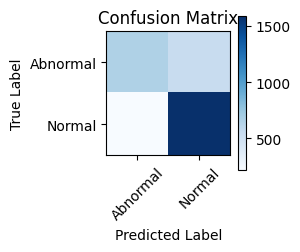

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute and plot confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
classes = train_dataset.classes
plt.figure(figsize=(len(classes), len(classes)))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
